# 멀티 에이전트 만들기

이 튜토리얼에서는 애플리케이션을 더 작고 독립적인 에이전트로 분할합니다.   
이러한 접근 방식은 모듈성, 전문성, 그리고 제어 기능을 제공합니다. 개별 에이전트를 개별적으로 처리하고, 전문가 에이전트를 생성하고, 에이전트 간의 통신 방식을 제어할 수 있습니다.

지금부터는 LangGraph를 사용하여 완전한 멀티 에이전트 시스템을 처음부터 구축하는 방법을 알아보겠습니다.   
이번 튜토리얼에서는 슈퍼바이저 에이전트 패턴의 멀티 에이전트 구조를 만들어 보겠습니다. 각 에이전트는 고유한 도구 세트를 가지고 있습니다.

<img src="statics/supervisor.png" />

## 1. 환경설정

In [1]:
%pip install -qU langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf 

Note: you may need to restart the kernel to use updated packages.


In [83]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:20])
print(os.environ.get("TAVILY_API_KEY")[:20])

## 2. LLM 선택

In [84]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini")

## 3. 웹검색 도구

In [85]:
# %pip install -qU langchain-tavily

In [86]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(max_results=2)

In [87]:
# 테스트

web_search_tool.invoke({"query": "2024 윔블던 테니스 남자 단식 우승자는 누구?"})

{'query': '2024 윔블던 테니스 남자 단식 우승자는 누구?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://m.blog.naver.com/womant30/223512854345',
   'title': '윔블던_2024_남자단식_우승자 #카를로스_알카라스 - 네이버 블로그',
   'content': '(서울=연합뉴스) 김동찬 기자 = 카를로스 알카라스(3위·스페인)가 윔블던 테니스 대회(총상금 5천만 파운드·약 875억원) 남자 단식 2연패를 달성했다.',
   'score': 0.93309647,
   'raw_content': None},
  {'url': 'https://blog.naver.com/choimy84/223508998381?viewType=pc',
   'title': '2024 윔블던 테니스대회 승자는 과연 누구. 4대 메이저 대회와 윔블던',
   'content': '남자 단식 우승은 알카라스가 차지하면서 지난대회에 이어 윔블던 2연패의 기록을 세웠습니다. 테니스 그랜드슬램은 테니스에서 가장 권위 있는 네 개의',
   'score': 0.9257218,
   'raw_content': None}],
 'response_time': 0.97}

## 4. Agentic RAG 도구

### LOAD

In [88]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_core.documents import Document

def load_documents(folder_path: str) -> list[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 28 documents from the folder.


### SPLIT

In [89]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
     chunk_size=1000,
     chunk_overlap=200,
     length_function=len
 )

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 71 chunks.


### EMBED

In [90]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [91]:
# from langchain_chroma import Chroma

# collection_name = "my_collection"
# vectorstore = Chroma.from_documents(
#     collection_name=collection_name,
#     documents=splits,
#     embedding=embeddings,
#     persist_directory="./chroma_db"
# )

### STORE

In [92]:
# %pip install -qU faiss-cpu

In [93]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(documents=splits, 
                                   embedding=embeddings)

### RETRIEVAL and TOOL

In [94]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
    """사용자 질문에 답하기 위해 의미적으로 유사한 내용을 AI브리프 문서에서 검색하는 도구"""
    print("===== RETRIEVER =====")
    retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
    retriever_results = retriever.invoke(question)
    return "\n\n".join(doc.page_content for doc in retriever_results)

In [95]:
### 테스트

retriever_tool.invoke("아마존에서 개발한 로봇의 이름은")


===== RETRIEVER =====


"KEY Contents\n£벌컨, 물품에 접촉하는 지점과 압력을 인식해 좁은 공간에서 물품 이동 능력 제고n아마존(Amazon)이 2025년 5월 7일 로봇공학과 엔지니어링, 피지컬 AI 분야의 핵심 기술을 활용해 제작된 물류 로봇 ‘벌컨(Vulcan)’을 공개∙이전까지는 산업용 로봇에 예상치 않은 접촉이 있으면 비상 정지하거나 접촉을 아예 감지하지 못하는 경우가 일반적이었으나, 벌컨은 촉각 기능을 갖춘 최초의 로봇이라는 점에서 기존 로봇과 차별화∙벌컨에는 처리 가능한 품목과 불가능한 품목을 식별하는 알고리즘과 같은 피지컬 AI 기술이 적용되었으며, 수천 가지 물품을 다루는 실제 사례로 훈련을 진행n아마존 물류센터는 약 0.093제곱미터 크기의 칸에 최대 10개의 상품을 보관하는데, 좁은 공간에서 물품을 잡기가 어려운 기존 산업용 로봇과 달리, 벌컨은 로봇 팔 끝에 부착된 장치(EOAT*)를 통해 물품에 접촉하는 지점과 가해지는 압력을 인식해 손상 없이 물품을 이동 가능   * End of Arm Tooling: 벌컨의 EoAT는 물품을 밀어내는 장치와 집게, 압력 피드백 센서 등으로 구성∙벌컨에 탑재된 집게 장치는 압력 피드백 센서를 바탕으로 물체의 크기와 모양에 따라 그립 강도를 조절할 수 있으며, 카메라로 수납공간을 확인해 물체를 가장 잘 잡을 수 있는 위치를 파악∙벌컨은 물류센터에 보관되는 모든 종류의 품목 중 약 75%를 픽업하고 적재할 수 있고 물품 픽업이 불가능한 경우 직원에게 도움을 청할 수 있으며, 현장 직원과 비슷한 속도로 작업을 진행∙아마존은 미국 워싱턴주와 독일 함부르크의 물류센터에 벌컨을 도입해 직원 안전과 인체공학을 개선하고 있으며, 향후 몇 년간 유럽과 미국 전역의 물류 현장에 벌컨 시스템을 구축할 계획이라고 설명\n <아마존의 물류 로봇 ‘벌컨’의 도입 현장>\n출처 | Amazon, Introducing Vulcan: Amazon's first robot with a sense of touch, 2025.05.07.\n\n정책･

## 5. SQL 도구

### DB 로드

DATABASE(Chinook, 쉬누크) 다운로드 사이트 : https://www.sqlitetutorial.net/sqlite-sample-database/

In [96]:
from langchain_community.utilities import SQLDatabase

# chinook.db 디지털 음악 상점
db = SQLDatabase.from_uri("sqlite:///./db/Chinook.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}') 


Dialect: sqlite
Available tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


### SQL 관련 도구 확인

In [97]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

sql_tools = toolkit.get_tools()

for tool in sql_tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## 6. 개별 에이전트 생성

### Web Search 에이전트

In [98]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.types import Command
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.prebuilt import tools_condition
from typing import Annotated, TypedDict, Literal, Sequence

def websearch_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    websearch_agent = create_react_agent(
        llm,
        [web_search_tool],
        prompt="당신은 사용자의 질문에 답변하기 위해서 웹 검색을 진행하는 에이전트입니다.",
    )
    
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [99]:
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="ChatGPT가 무엇인가요?", name="user")
])

# 5. 함수 호출 및 결과 확인
result = web_research_node(initial_state)

# 6. 출력 보기
print("🔍 웹 리서치 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

🔍 웹 리서치 결과:
[web_researcher] ChatGPT는 OpenAI에서 개발한 대화형 인공지능 모델로, 자연어 처리 기술을 이용하여 인간과의 대화를 이해하고 생성하는 시스템입니다. 이 모델은 광범위한 데이터를 기반으로 훈련되어 있으며, 다양한 주제에 대해 질문에 답변하거나 정보를 제공할 수 있습니다. ChatGPT는 사용자와의 상호작용을 통해 학습하며, 자연스러운 대화를 지원합니다.
다음 이동: supervisor


### RAG 에이전트

In [100]:
from langchain_core.messages import HumanMessage, SystemMessage

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    rag_agent = create_react_agent(
        llm,
        [retriever_tool],
        prompt="당신은 문서와 관련된 사용자 질문에 답변하기 위해 의미적으로 유사한 문서를 검색하는 에이전트입니다.",
    )
    
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )


In [101]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="아마존에서 개발한 로봇은 무엇인가?", name="user")
])

# 함수 호출 및 결과 확인
result = rag_node(initial_state)

# 6. 출력 보기
print("🔍 웹 리서치 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")


===== RETRIEVER =====
🔍 웹 리서치 결과:
[rag] 아마존에서 개발한 로봇은 '벌컨(Vulcan)'입니다. 이 로봇은 2025년 5월 7일 공개되었으며, 물품에 접촉하는 지점과 압력을 인식하여 좁은 공간에서 물품 이동 능력을 향상시키는 기능을 가지고 있습니다. 벌컨은 촉각 기능을 갖춘 최초의 로봇으로, 처리 가능한 품목과 불가능한 품목을 식별하는 알고리즘이 적용되어 있습니다.

벌컨은 로봇 팔 끝에 부착된 장치를 통해 물품에 접촉하는 지점과 가해지는 압력을 인식하여, 손상 없이 물품을 이동할 수 있는 능력을 가지고 있습니다. 이 로봇은 물류센터에 보관되는 모든 종류의 품목 중 약 75%를 픽업하고 적재할 수 있으며, 물품 픽업이 불가능한 경우에는 직원에게 도움을 요청할 수 있습니다.

아마존은 이미 미국 워싱턴주와 독일 함부르크의 물류센터에 벌컨을 도입하여 직원 안전과 인체공학을 개선하고 있으며, 향후 몇 년간 유럽과 미국 전역의 물류 현장에 벌컨 시스템을 구축할 계획입니다.
다음 이동: supervisor


### SQL 에이전트

In [106]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
당신은 SQL 데이터베이스와 상호작용하도록 설계된 에이전트입니다.  
입력 질문을 받으면, 실행할 문법적으로 올바른 {dialect} 쿼리를 생성한 다음,  
쿼리 결과를 확인하고 답변을 반환하세요.  
사용자가 원하는 예제 수를 명시하지 않는 한, 쿼리 결과는 항상 최대 {top_k}개로 제한하세요.

결과는 데이터베이스에서 가장 흥미로운 예제를 반환할 수 있도록 관련 열로 정렬할 수 있습니다.  
특정 테이블에서 모든 열을 조회하지 마시고, 질문에 관련된 열만 요청하세요.

쿼리를 실행하기 전에 반드시 두 번 확인하세요.  
쿼리를 실행하는 도중 오류가 발생하면, 쿼리를 다시 작성해서 재시도하세요.

데이터베이스에 DML 문(INSERT, UPDATE, DELETE, DROP 등)을 절대로 실행하지 마세요.

처음에는 반드시 데이터베이스의 테이블을 확인하여 어떤 항목을 조회할 수 있는지 파악하세요.  
이 단계를 건너뛰지 마세요.

그 다음으로는 가장 관련 있는 테이블의 스키마를 조회하세요.
""".format(
    dialect=db.dialect,
    top_k=5,
)


In [107]:
def sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    sql_agent = create_react_agent(
        llm,
        sql_tools,
        prompt=system_prompt,
    )
    
    result = sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [108]:
## 테스트 

# 테스트용 입력 생성
initial_state = MessagesState(messages=[
    HumanMessage(content="2009년에 판매 실적이 가장 높았던 영업 사원은 누구인가요?", name="user")
])

# 함수 호출 및 결과 확인
result = sql_node(initial_state)

# 6. 출력 보기
print("🔍 DB 쿼리 결과:")
for msg in result.update["messages"]:
    print(f"[{msg.name}] {msg.content}")
print(f"다음 이동: {result.goto}")

🔍 DB 쿼리 결과:
[rag] 2009년에 판매 실적이 가장 높았던 영업 사원은 **Nancy Edwards**로, 총 판매 금액은 **24.75**입니다.
다음 이동: supervisor


## 7. 감독자 에이전트 생성

감독 에이전트는 여러 전문 에이전트 간의 대화 흐름을 관리합니다. 현재 요청을 어떤 에이전트가 처리해야 하는지, 그리고 작업 완료 시점을 결정합니다. 이를 구현하는 방법을 살펴보겠습니다.

In [134]:
from pydantic import BaseModel, Field

class Router(BaseModel):
    next: Literal["websearch_agent", "sql_agent", "rag_agent", "FINISH", "__end__"] = Field(
        description="워크플로우 순서에서 다음으로 활성화할 전문가를 결정합니다: "
                    "'websearch_agent'는 사용자 입력에 웹 검색이 필요한 경우 사용됩니다. "
                    "'sql_agent'는 데이터베이스(DB) 검색이 필요한 경우 사용됩니다. "
                    "'rag_agent'는 AI브리프의 문서 내용 검색이 필요한 경우 사용됩니다. "
    )
    reason: str = Field(
        description="특정 전문가를 선택한 결정에 대한 자세한 정당화로, 선택한 이유와 이 선택이 과업을 완수하는 데 어떻게 기여하는지를 설명합니다."
    )

In [135]:
def supervisor_node(state: MessagesState) -> Command[Literal["websearch_agent", "sql_agent", "rag_agent", "__end__"]]:

    system_prompt = ('''

        당신은 websearch_agent, sql_agent, rag_agent, 이렇게  3개의 전문 에이전트로 구성된 팀을 관리하는 워크플로우 감독자입니다. 당신의 역할은 작업의 현재 상태와 요구 사항에 따라 가장 적절한 다음 에이전트를 선택하여 워크플로우를 조율하는 것입니다. 각 결정에 대해 명확하고 간결한 근거를 제공하여 의사결정 과정을 투명하게 유지하십시오.
        
        **팀 구성원**:
        1. **websearch_agent**: 사용자의 질문이 최신의 정보를 요청하거나 웹검색을 요청하는 경우 이 에이전트가 처리합니다.
        2. **sql_agent**: 데이터베이스에 관련된 사용자의 질문에 답하기 위해서는 이 에이전트가 처리합니다.
        3. **rag_agent**: AI브리프 문서의 내용을 참고하거나 검색하는 경우 이 에이전트가 처리합니다.
        
        **당신의 책임**:
        1. 각 결정 시점에서 작업을 가장 적절한 에이전트에게 라우팅합니다.
        2. 중복되는 에이전트 할당을 피하여 워크플로우의 효율성을 유지합니다.
        3. 사용자의 질문에 대한 충분한 응답이 생성되었고, 더 이상 추가적인 작업이 필요하지 않다면 'FINISH' 또는 '__end__'를 리턴하십시오.
    ''')

    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == "__end__":
        print("***** END *****")
        goto = END
    
    print(f"📌--- Workflow Transition: Supervisor → {goto.upper()} ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,
    )

슈퍼바이저 에이전트는 다음과 같이 작동합니다.

1. 현재 대화 상태를 입력으로 사용
1. 시스템 프롬프트를 사용하여 해당 역할을 이해합니다.
1. 다음에 어떤 에이전트가 행동해야 할지 결정합니다.
1. 선택한 에이전트로 흐름을 지시하는 명령을 반환합니다.

## 8. 그래프 구축

내부적으로 `Command`를 사용하고 있어서, `edge` 추가는 명시적으로 하지 않는다.

In [136]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(MessagesState)
builder.add_node("supervisor", supervisor_node)
builder.add_node("websearch_agent", websearch_node)
builder.add_node("rag_agent", rag_node)
builder.add_node("sql_agent", sql_node)
builder.add_edge(START, "supervisor")
graph = builder.compile()


이를 통해 다음과 같은 완전한 다중 에이전트 시스템이 생성됩니다.

1. 감독자는 초기 요청을 받습니다.
1. 해당 전문 에이전트에게 요청을 라우팅합니다.
1. 전문 에이전트는 도구를 사용하여 요청을 처리합니다.
1. 다음 단계를 결정하기 위해 통제권이 감독자에게 반환됩니다.
1. 감독자가 작업이 완료되었다고 판단할 때까지 프로세스가 계속됩니다.

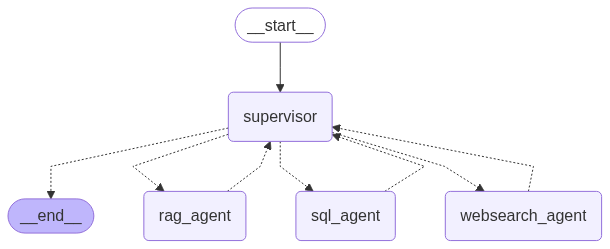

In [137]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 9. 실행

In [142]:
# Example: Complex Query Using Multiple Agents
# input_question = "데이터베이스를 검색해서 2009년에 판매 실적이 가장 높았던 영업 사원을 찾아주세요."
input_question = "데이터베이스에서 가장 많이 판매된 앨범을 찾아서, 그 앨범의 상세 내용을 웹에서 검색해서 정리해줘."
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")


📌--- Workflow Transition: Supervisor → SQL_AGENT ---
((), {'supervisor': {'messages': [HumanMessage(content='사용자의 질문은 데이터베이스에서 가장 많이 판매된 앨범을 찾는 것이므로, sql_agent가 데이터베이스와 관련된 쿼리를 처리하는 데 적합합니다.', additional_kwargs={}, response_metadata={}, name='supervisor')]}})
----
(('sql_agent:2f8d0682-6e1b-05eb-4d65-6440cb0e482e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Y1GAkDAMMQp1VFcOeDeWsRGu', 'function': {'arguments': '{}', 'name': 'sql_db_list_tables'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 657, 'total_tokens': 669, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqYejn9WnzHCHMyQIOtvJL1sDIee3', 'service_tier': 'defau

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


***** END *****
📌--- Workflow Transition: Supervisor → __END__ ---
((), {'supervisor': {'messages': [HumanMessage(content="앨범 'Minha Historia'에 대한 상세 정보를 성공적으로 웹에서 검색하여 제공하였고, 추가적인 작업이 필요하지 않습니다.", additional_kwargs={}, response_metadata={}, name='supervisor')]}})
----
